In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [3]:
import pandas as pd
import numpy as np
import time

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Dropout
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt


In [4]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Read dataset
path = '/content/drive/My Drive/imdb/Dataset.csv'
df = pd.read_csv(path)
print(df.shape)
print(df.head(3))

df = df[['review','sentiment']]
#create a new column in the dataframe
df['label'] = df['sentiment']
print(df.head(3))

print(df.groupby('sentiment').count())
#change values in the column label based on values
df.label.replace(to_replace ="positive", value = 1, inplace = True)
df.label.replace(to_replace ="negative", value = 0, inplace = True)
print(df.head(5))


(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
                                              review sentiment     label
0  One of the other reviewers has mentioned that ...  positive  positive
1  A wonderful little production. <br /><br />The...  positive  positive
2  I thought this was a wonderful way to spend ti...  positive  positive
           review  label
sentiment               
negative    25000  25000
positive    25000  25000
                                              review sentiment  label
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative   

In [7]:
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [8]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
import string
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
### Cleaning up the text
def clean_text(text):  
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split() #default separator is any whitespace.
    #print("text: ", text)
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)    ## Clean the text
    #print("text1: ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #Here is a regex to match a string of characters that are not a letters or numbers
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)  
    
    ## Stemming
    text = text.split()
    #print("text2: ", text)
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text] 
    text = " ".join(stemmed_words)
    #print("text3: ", text)
    return text

In [11]:
# apply the above function to df['text']
df['review'] = df['review'].map(lambda x: clean_text(x)) # It executes the function_object for each element in the sequence and 
                                                         # returns a list of the elements modified by the function object.



In [13]:
df.head()

,review,sentiment,label
0,one review mention watch episod hook right exa...,positive,1
1,wonder littl product <br <br the film techniqu...,positive,1
2,thought wonder way spend time hot summer weeke...,positive,1
3,basic there famili littl boy jake think there ...,negative,0
4,petter mattei love time money visual stun film...,positive,1


For example, consider the sentence " The earth is an awesome place live"

tokenizer.fit_on_texts("The earth is an awesome place to live") fits [[1,2,3,4,5,6,7,8]] where 3 -> "is" , 6 -> "place", so on. 

sequences = tokenizer.texts_to_sequences("The earth is an great place to live") returns [[1,2,3,4,6,7,8]].

In [16]:
#TO DO:
tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(["The earth is an awesome place to live", "The house is an amazing place to live"])

#TO DO: get some statistics
print(tokenizer_test.word_index)
vocab_size = len(tokenizer_test.word_index) + 1 # !!! adding 1 because of reserverd 0 index #So that the word indexes are 1-offset, and 0 is reserved for no data.
print("vocabulary size: ", vocab_size)

for word, index in tokenizer_test.word_index.items():
  print(word, index)

{'the': 1, 'is': 2, 'an': 3, 'place': 4, 'to': 5, 'live': 6, 'earth': 7, 'awesome': 8, 'house': 9, 'amazing': 10}
vocabulary size:  11
the 1
is 2
an 3
place 4
to 5
live 6
earth 7
awesome 8
house 9
amazing 10


In [17]:
#TO DO
sequence_test = tokenizer_test.texts_to_sequences(["The earth is an great place to live"]) #each word into an integer
print("tokenized sequence: ", sequence_test, len(sequence_test[0]), len(("The earth is an great place to live").split()))


tokenized sequence:  [[1, 7, 2, 3, 4, 5, 6]] 7 8


In [20]:

RANDOM_STATE = 42
#TO DO: add review to X and Y

X = df["review"].fillna('').to_list() #NaN
X = [str(i) for i in X]
y = df["label"].fillna('').to_list()

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)
print(text_train[0])
print(text_train[1])

#TO DO : 
# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test  = tokenizer.texts_to_sequences(text_test)
print("X_train[0]",X_train[0])

#TO DO: get some statistics
vocab_size = len(tokenizer.word_index) + 1 # adding 1 because of reserverd 0 index
print("vocabulary size: ", vocab_size)

maxlen_train = max( len(x) for x in X_train)
maxlen_test = max( len(x) for x in X_test)

print("maxlen train dataset: ", maxlen_train)
print("maxlen test dataset: ", maxlen_test)


recent start watch show say realli made laugh appreci unrealist aspect it along everyth els peopl said show realist reaction dead among thing go accept ned bring dead back life accept complet crazi bit show help smile everi episod watch realli think great show take strang subject realli make great watch absolut love narrat think add extra bit wonder whole show ca not alway compar old show writer new one take everyth entiti definit give chanc enjoy ridicul part are
return jedi often rememb wrong rather right shame last chronolog instal star war saga shine exampl epic storytel manag wrap stori line previous movi one grand final convinc <br <br yes ewok cute cudd bear arguabl serv broaden star war demograph middl movi tend slow bit final hour arguabl best piec entir saga luke final come face face darth vader recogniz villain movi histori <br <br return jedi mani thing right peopl tend overlook : present incred conclus darth vader storylin which went slight implaus empir strike back convin

In [21]:
#TO DO: 
# 
maxlen = maxlen_train

X_train = pad_sequences(X_train, padding= "post", maxlen = maxlen)
X_test = pad_sequences(X_test, padding ="post" , maxlen = maxlen)

In [22]:
X_test[1]
#X_train.shape

array([ 48, 654,  22, ...,   0,   0,   0], dtype=int32)

In [23]:
#X_test[0]
X_test.shape

(5000, 1461)


Example:

doc_1="bitty bought a bit of butter"

doc_2="but the bit of butter was a bit bitter"

doc_3="so she bought some better butter to make the bitter butter better"


The encoding for document 1  is :  [45, 16, 32, 27, 34, 33]

The encoding for document 2  is :  [24, 2, 27, 34, 33, 37, 32, 27, 3]

The encoding for document 3  is :  [22, 27, 16, 28, 35, 33, 7, 2, 2, 3, 33, 35]



---



PADDING THE DOCS (to make very doc of same length)

The maximum number of words in any document is :  12

The padded encoding for document 1  is :  [45 16 32 27 34 33  0  0  0  0  0  0]

The padded encoding for document 2  is :  [24  2 27 34 33 37 32 27  3  0  0  0]

The padded encoding for document 3  is :  [22 27 16 28 35 33  7  2  2  3 33 35]


---
ACTUALLY CREATING THE EMBEDDINGS using KERAS EMBEDDING LAYER

word_input=Input(shape=(maxlen,),dtype='float64')  
Embedding(input_dim=vocab_size,output_dim=8,input_length=maxlen)


---


PARAMETERS OF THE EMBEDDING LAYER ---

'input_dim' = the vocab size that we will choose. In other words it is the number of unique words in the vocab.

'output_dim' = the number of dimensions we wish to embed into. Each word will be represented by a vector of this much dimensions.

'input_length' = lenght of the maximum document. which is stored in maxlen variable in our case.

---


The resulting shape is (3,12,8).


3---> no of documents

12---> each document is made of 12 words which was our maximum length of any document.

& 8---> each word is 8 dimensional.

embedding of the doc_1: where is word is encoded with a vector of size 8:

Shape of embeddings :  (3, 12, 8)

[[ 0.00501078 -0.02695217  0.00602702  0.00266289  0.03473682
    0.0097171   0.01049457  0.04075214]

  [-0.01465576 -0.03764923  0.02566164 -0.03778331  0.00713614
    0.04891029 -0.04066588  0.04367645]

  [ 0.02802004  0.03197568 -0.03032377 -0.04005457  0.04845554
    0.04599163  0.03079205  0.00011758]

  [ 0.0425863   0.01251983 -0.00086614  0.01517198  0.03247393
   -0.0487391   0.01155691 -0.02174735]

  [ 0.01364631 -0.03071666  0.04824429  0.01273396 -0.04050324
   -0.02806609  0.02730856 -0.00130756]

  [ 0.00662886  0.01568889 -0.02373004 -0.02203096  0.04081896
    0.04661508 -0.0180509  -0.01726084]

  [-0.04217806 -0.04307245 -0.02673855  0.03635491 -0.01157793
   -0.00228085 -0.00746915  0.03362348]

  [-0.04217806 -0.04307245 -0.02673855  0.03635491 -0.01157793
   -0.00228085 -0.00746915  0.03362348]

  [-0.04217806 -0.04307245 -0.02673855  0.03635491 -0.01157793
   -0.00228085 -0.00746915  0.03362348]

  [-0.04217806 -0.04307245 -0.02673855  0.03635491 -0.01157793
   -0.00228085 -0.00746915  0.03362348]

  [-0.04217806 -0.04307245 -0.02673855  0.03635491 -0.01157793
   -0.00228085 -0.00746915  0.03362348]

  [-0.04217806 -0.04307245 -0.02673855  0.03635491 -0.01157793
   -0.00228085 -0.00746915  0.03362348]]



In [24]:
#TO DO:
# Define MLP architecture
embedding_dim = 100

model_dense = Sequential()

model_dense.add(Embedding(vocab_size, embedding_dim, input_length = maxlen)) #output 3d (batch_size, input_length, output_dim) -> 

#we have to go from 3D to 1D

model_dense.add(Flatten())

model_dense.add(Dense(128, activation = "relu"))
#add dropout if necessary xD
model_dense.add(Dense(64, activation = "relu"))

# model_dense.add(Dense(2, activation = "softmax"))

model_dense.add(Dense(1, activation = "sigmoid"))

#end of model architecture

model_dense.compile(optimizer = "adam", loss ="binary_crossentropy", metrics = ["accuracy"] )

model_dense.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1461, 100)         6995400   
                                                                 
 flatten (Flatten)           (None, 146100)            0         
                                                                 
 dense (Dense)               (None, 128)               18700928  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,704,649
Trainable params: 25,704,649
Non-trainable params: 0
_________________________________________________________________


In [25]:
#TO DO:
# Fit model and get the history
history = model_dense.fit(np.array(X_train), np.array(y_train), epochs=1,verbose=True, validation_data=(np.array(X_test), np.array(y_test)),batch_size=32)


1407/1407 [==============================] - 21s 13ms/step - loss: 0.3426 - accuracy: 0.8430 - val_loss: 0.2686 - val_accuracy: 0.8934


In [26]:
#TO DO : evaluate the model 
loss, accuracy = model_dense.evaluate(np.array(X_test), np.array(y_test), verbose = 1 )


157/157 [==============================] - 0s 3ms/step - loss: 0.2686 - accuracy: 0.8934


In [27]:
history.history

{'accuracy': [0.84297776222229],
 'loss': [0.3425546884536743],
 'val_accuracy': [0.8934000134468079],
 'val_loss': [0.26855596899986267]}

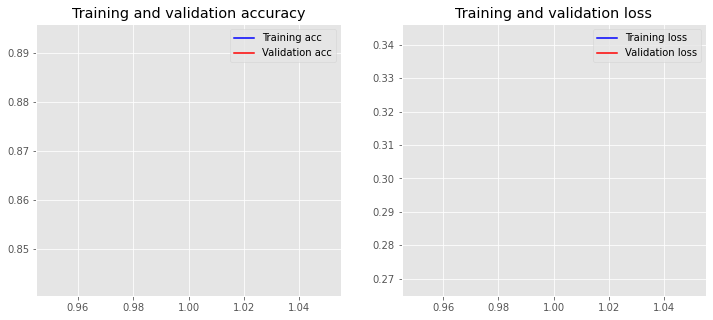

In [28]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)

In [31]:
#TO DO : predictions on new sample

x_sample = ["this movie is bad"]

x_sample = tokenizer.texts_to_sequences(x_sample)
print(np.array(x_sample).shape)

x_sample = pad_sequences(x_sample, padding = "post", maxlen = maxlen)
print(x_sample.shape)

#print(model_dense.predict(x_sample))
y_sample = model_dense.predict(x_sample)

print(y_sample)
#print("Prediction: ", np.argmax(y_sample))

if y_sample <= 0.5:
  print('Prediction: ', 0)
else:
  print('Prediction: ', 1)

(1, 4)
(1, 1461)
[[0.44650367]]
Prediction:  0


**Use pre-trained Glove word embeddings**

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

In [32]:
#TO DO : get read the glove embedding from google drive and create dictionary : word->embedding
#/content/drive/My Drive/imdb/Dataset.csv
embeddings_index = dict()
f = open('/content/drive/My Drive/imdb/glove.6B.50d.txt')

for line in f: 
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:], dtype = "float32")
  embeddings_index[word] = coefs

f.close()

In [34]:
embeddings_index
print(len(embeddings_index))

400000


In [35]:
#embeddings_index["of"] #.shape -> 50 which is the embedding dimensions
embeddings_index.get("house")

array([ 0.60137  ,  0.28521  , -0.032038 , -0.43026  ,  0.74806  ,
        0.26223  , -0.97361  ,  0.078581 , -0.57588  , -1.188    ,
       -1.8507   , -0.24887  ,  0.055549 ,  0.0086155,  0.067951 ,
        0.40554  , -0.073998 , -0.21318  ,  0.37167  , -0.71791  ,
        1.2234   ,  0.35546  , -0.41537  , -0.21931  , -0.39661  ,
       -1.7831   , -0.41507  ,  0.29533  , -0.41254  ,  0.020096 ,
        2.7425   , -0.9926   , -0.71033  , -0.46813  ,  0.28265  ,
       -0.077639 ,  0.3041   , -0.06644  ,  0.3951   , -0.70747  ,
       -0.38894  ,  0.23158  , -0.49508  ,  0.14612  , -0.02314  ,
        0.56389  , -0.86188  , -1.0278   ,  0.039922 ,  0.20018  ],
      dtype=float32)

In [38]:
#TO DO : create embedding_matrix using the embedding_index dictionary and the tokenizer dictionary

embeddings_matrix = np.zeros((vocab_size, 50))
hits = 0
misses = 0

for word, index in tokenizer.word_index.items():
  print(word, index)
  if index > vocab_size-1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Streaming output truncated to the last 5000 lines.
poetess 64955
dottor 64956
padua 64957
libeskind 64958
potboiler 64959
taptieg24 64960
brosan 64961
cantaker 64962
hallstrom 64963
iwil 64964
rus 64965
trecki 64966
alohalani 64967
lamein 64968
babaganoosh 64969
sceam 64970
ependip 64971
eislin 64972
oxfam 64973
healthcar 64974
vittl 64975
karakoram 64976
waddington 64977
messner 64978
stonefac 64979
magictrain 64980
aron 64981
bracker 64982
ortens 64983
deleteri 64984
trying 64985
onesself 64986
walked 64987
underexplain 64988
bizniss 64989
stylophon 64990
gothamit 64991
marstoni 64992
ackward 64993
scenerari 64994
paprika 64995
exsquisit 64996
pla 64997
batb 64998
lizbeth 64999
charistmat 65000
ubba 65001
alfven 65002
berenstein 65003
toretton 65004
emmannuell 65005
assult 65006
maniquen 65007
womman 65008
friedland 65009
hayday 65010
slowish 65011
warbler 65012
caplan 65013
kerkour 65014
cracki 65015
syne 65016
derrida 65017
crimmini 65018
ehhh 65019
sorcia 65020
chromium 65021
deri

In [36]:
print(tokenizer.word_index.items())
print(len(tokenizer.word_index.items()))
print(vocab_size)

dict_items([('br', 1), ('movi', 2), ('film', 3), ('one', 4), ('like', 5), ('time', 6), ('i', 7), ('it', 8), ('good', 9), ('make', 10), ('would', 11), ('the', 12), ('charact', 13), ('see', 14), ('watch', 15), ('get', 16), ('even', 17), ('stori', 18), ('realli', 19), ('well', 20), ('scene', 21), ('show', 22), ('look', 23), ('bad', 24), ('much', 25), ('end', 26), ('great', 27), ('peopl', 28), ('love', 29), ('also', 30), ('first', 31), ('think', 32), ('act', 33), ('play', 34), ('way', 35), ('thing', 36), ('made', 37), ('could', 38), ('know', 39), ('say', 40), ('seem', 41), ('that', 42), ('not', 43), ('plot', 44), ('work', 45), ('two', 46), ('actor', 47), ('mani', 48), ('seen', 49), ('come', 50), ('year', 51), ('want', 52), ('take', 53), ('never', 54), ('life', 55), ('best', 56), ('tri', 57), ('this', 58), ('littl', 59), ('ever', 60), ('man', 61), ('there', 62), ('give', 63), ('better', 64), ('still', 65), ('find', 66), ('and', 67), ('perform', 68), ('part', 69), ('feel', 70), ('someth', 71

In [39]:
tokenizer.document_count

45000

In [40]:
print(list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(3)]) 
print(list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(2)]) 

film
movi


In [ ]:
#tokenizer.word_index

In [41]:
print(embeddings_matrix[3])
print(embeddings_matrix[2])

[ 0.06912     0.22159    -0.66613001 -0.14060999  0.063365    0.41747001
 -0.21723001 -1.04009998  0.026069    1.33819997 -0.083642    0.66324002
 -0.45989001  0.95883     1.31850004 -0.62523001  0.56152999  0.65288001
 -1.23640001  0.29692     1.23800004  0.80620998  0.40967     0.39945
  0.57982999 -1.36580002 -1.67639995  0.069718   -0.59634    -0.63116997
  2.58940005 -0.56914997  0.46878999 -0.9249     -0.44628999  0.42282999
  0.17636999 -0.014459   -0.75357997 -0.97850001  0.023075    1.2227
 -0.17517    -1.57430005 -0.95349997 -0.10959     0.24517    -0.93550998
 -0.20942999  0.67333001]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [42]:
# TO DO : 
## create model using the embedding_matrix from glove pretrained word-to-vector model
model_glove = Sequential()

model_glove.add (Embedding(vocab_size, 50, input_length=maxlen, weights = [embeddings_matrix], trainable = False ))
#we have to go from 3d to 1d

model_glove.add(Flatten())


#add dropout if necessary xD
model_glove.add(Dense(64, activation = "relu"))

# model_dense.add(tf.keras.layers.Dense(2, activation = "softmax"))

model_glove.add(Dense(1, activation = "sigmoid"))

#end of model architecture

model_glove.compile(optimizer = "adam", loss ="binary_crossentropy", metrics = ["accuracy"] )

model_glove.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1461, 50)          3497700   
                                                                 
 flatten_1 (Flatten)         (None, 73050)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                4675264   
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,173,029
Trainable params: 4,675,329
Non-trainable params: 3,497,700
_________________________________________________________________


In [44]:
#TO DO : fit the model
model_glove.fit(np.array(X_train), np.array(y_train), epochs=10,verbose=True, validation_data=(np.array(X_test), np.array(y_test)),batch_size=32)


Epoch 1/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5067 - accuracy: 0.7485 - val_loss: 0.5874 - val_accuracy: 0.6914
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.4176 - accuracy: 0.8013 - val_loss: 0.6552 - val_accuracy: 0.6926
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3104 - accuracy: 0.8598 - val_loss: 0.7860 - val_accuracy: 0.6750
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2077 - accuracy: 0.9137 - val_loss: 0.9789 - val_accuracy: 0.6694
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1334 - accuracy: 0.9472 - val_loss: 1.2498 - val_accuracy: 0.6732
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0855 - accuracy: 0.9669 - val_loss: 1.4955 - val_accuracy: 0.6768
Epoch 7/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0642 - accuracy: 0.9748 - val_loss: 1.6478 - val_accuracy: